# Creating and Updating a did:btc1 Identifier
## A `did:btc1` Demo

In this demo you will learn:

1. How to create a did:btc1 Decentralized Identifier (DID) from an external intermediate DID document.
2. How to construct a BTC1 Update that mutates the initial DID document.
3. How to announce and anchor this BTC1 Update to the Bitcoin blockchain using a BTC1 Beacon.
4. How to resolve the did:btc1 identifier using the Universal Resolver.

# High level outline

1. **Key Management**: Generate a BIP32 seed phrase, HD Key and derive the required cryptographic key material needed for the signing and Beacon operations in this workshop.
2. **did:btc1 identifier construction**: Construct a did:btc1 identifier and its associated capabilities in a valid DID document.
3. **Resolving a did:btc1 identifier using Sidecar Data**: Construct the Sidecar Data required to resolve an external did:btc1 identifier and execute a resolution request through the universal resolver
4. **Construct a BTC1 Update**: Construct and invoke a BTC1 Update to add a new Verification Method to a did:btc1 DID document.
5. **Announce a BTC1 Update**: Announce the BTC1 Update by broadcasting a Beacon Signal from the SingletonBeacon defined within the DID document.
6. **Resolve updated did:btc1 identifier**: Construct the Sidecar Data necessary to resolve the updated did:btc1 identifier using the universal resolver.

# 0. Config

In [49]:
# What Bitcoin network do you want the identifier to be rooted to?
did_network = "mutinynet"
network_type = "signet"

# 1. Key Management

did:btc1 makes use of public key cryptography for secure interactions. Specifically it uses secp256k1 public and private keypairs, the type of keys that are used to secure and authorize Bitcoin transactions. A DID controller needs the ability to create and manage a multitude of these cryptographic keys and their association within different did:btc1 DID documents. This is similar to the requirement for Bitcoin wallets who must manage the keys the control specific Bitcoin addresses and the UTXOs these addresses secure.

You can think of it like a keyring.

<img src="./images/keyring.png" width="300px"/>


## 1.1. Generate HD root from secure mnemonic

In [51]:
from buidl.hd import secure_mnemonic, HDPrivateKey
mnemonic = 'bicycle bid language artwork minimum case cream ill tribe dragon stage trophy convince kiwi drift salmon destroy transfer retire knock rifle humble bench drift'

########
# Uncomment if you want to use your own mnemonic
########
# mnemonic = secure_mnemonic()
# print(mnemonic)

hd_root = HDPrivateKey.from_mnemonic(mnemonic)

## 1.2. Derive keypair for a verificationMethod

A verificationMethod is for defining cryptographic material that can participate in verifiable interactions.

In [52]:
key_index = 0

# This could be anything. Just picking a derivation path non standard in the btc community.
did_purpose = "111"

vm_sk = hd_root.get_private_key(did_purpose, address_num=key_index)
vm_pk = vm_sk.point

## 1.3. Derive keypair for a SingletonBeacon Service

This is the BTC1 Beacon that is used to announce updates to the DID document. We will not be using this Beacon in this workshop, but all `did:btc1` identifiers should contain at least one SingletonBeacon.

In [53]:
# Need to increment so we get a different key each time
key_index+=1

singleton_sk = hd_root.get_private_key(did_purpose, address_num=key_index)
singleton_pk = singleton_sk.point

# 2. did:btc1 Identifier Construction

We are going to construct a did:btc1 identifier from an external intermediate DID document. This can be an arbitrarily complex DID document, containing as many verification methods, verification relationships and services as the DID controller wishes. The DID document is an intermediate DID document because it does not contain the did:btc1 identifier, the hash of the intermediate DID document is used as the genesis bytes for the did:btc1 identifier. Once generated the initial, version 1, DID document can be constructed by replacing placeholder values with the did:btc1 identifier.

In this manner the did:btc1 identifier cryptographically commits to its initial DID document.

In this demo we will create an intermediate DID document with one verification method and one Singleton Beacon service. The verification method will be authorized for the capabilityInvocation and assertionMethod verification relationships.

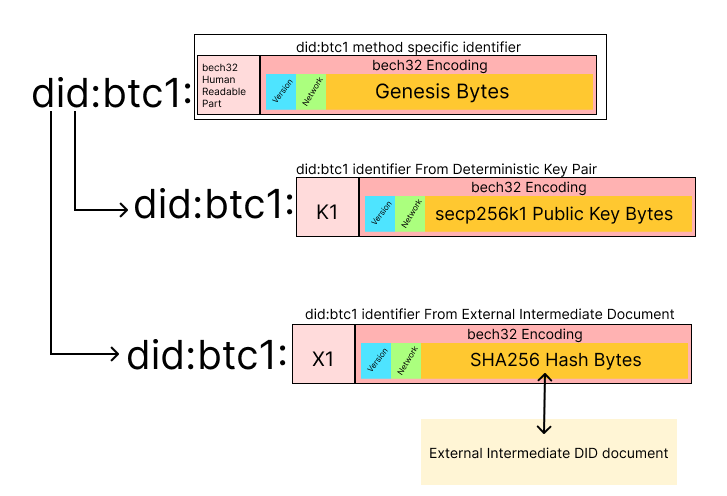

## 2.1. Instantiate a Builder for an IntermediateBtc1DIDDocument

This builder constructs the instantiating intermediate document that is used to generate the `did:btc1` identifier, binding the initial state of the DID document with the identifier itself.

In [86]:
from libbtc1.diddoc.builder import IntermediateBtc1DIDDocumentBuilder
from libbtc1.did import PLACEHOLDER_DID

# A placeholder that is put everywhere the actual did:btc1 identifier should be once it is constructed
print(PLACEHOLDER_DID)

builder = IntermediateBtc1DIDDocumentBuilder()


did:btc1:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


## 2.2. Add a VerificationMethod to the DID document

In [87]:
from libbtc1.multikey import get_public_key_multibase
from pydid.verification_method import Multikey

# Convert to multibase representation of public key bytes
pk_multibase = get_public_key_multibase(vm_pk.sec())

vm = builder.verification_method.add(Multikey, controller=PLACEHOLDER_DID, public_key_multibase = pk_multibase)

In [88]:
vm

Multikey(id='did:btc1:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx#key-0', type='Multikey', controller='did:btc1:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', public_key_hex=None, public_key_base58=None, public_key_pem=None, public_key_multibase='zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi', blockchain_account_id=None, ethereum_address=None, public_key_jwk=None)

## 2.3. Add `assertionMethod` Verification Relationship to DID document

When you make a VerifiableStatement you will use the VerificationMethod from 2.2. to sign a VerifiableCredential with the proofPurpose of `assertionMethod`. 
    In this step, you are letting anyone who resolves your DID document know you intend to use the Verification Method for this purpose.

In [89]:
builder.assertion_method.reference(vm.id)

## 2.4. Add `capabilityInvocation` Verification Relationship to DID document

This is the same as step 2.3., but for the `capabilityInvocation` relationship. All `did:btc1` documents should have at least one Verification Method able to execute capability invocations, this is how they authorize updates to the DID document. In this set of notebooks we will not be updating the DID document.

*Note: Technically, it is best practice to have separate Verification Methods for these different verification relationships. For simplicity I have not done this.*

In [90]:
builder.capability_invocation.reference(vm.id)

## 2.5. Add SingletonBeacon service to DID document

The SingletonBeacon provides a mechanism for the DID controller to announce and anchor to the Bitcoin blockchain through a Beacon Signal that they have made an update to the DID document. A DID controller can have multiple Beacons for this purpose in their DID document, including Beacons that aggregate multiple updates from distinct `did:btc1` identifiers. In this series of notebooks, we will not be updating the DID document.

In [91]:
# Generate Beacon script and address for SingletonBeacon
beacon_script = singleton_pk.p2wpkh_script()
address = beacon_script.address(network=network_type)

# Spends from this address should be considered Beacon Signals
# These signals should be processed according to the type of the Beacon as defined in the DID document
print("SingletonBeacon address: ", address)

beacon_service = builder.service.add_singleton_beacon(beacon_address=address)

SingletonBeacon address:  tb1qtmshuqzeyr7cdh5t2nl6kf3s73fdynpj5apgtx


## 2.6. Construct did:btc1 DID document

In [92]:
from libbtc1.did_manager import DIDManager
import json

intermediate_doc = builder.build()

print("\nIntermediate DID Document: ")
print(json.dumps(intermediate_doc.serialize(), indent=2))

did_manager = DIDManager(did_network=did_network, btc_network=network_type)

btc1_identifier, did_doc = did_manager.create_external(intermediate_doc, did_network)

print("\n\n")
print(btc1_identifier)
print("\nDID Document: ")
print(json.dumps(did_doc.serialize(), indent=2))

v1_did_document = did_doc.model_copy(deep=True)



Intermediate DID Document: 
{
  "@context": [
    "https://www.w3.org/TR/did-1.1",
    "https://did-btc1/TBD/context"
  ],
  "id": "did:btc1:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx",
  "verificationMethod": [
    {
      "id": "did:btc1:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx#key-0",
      "type": "Multikey",
      "controller": "did:btc1:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx",
      "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
    }
  ],
  "assertionMethod": [
    "did:btc1:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx#key-0"
  ],
  "capabilityInvocation": [
    "did:btc1:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx#key-0"
  ],
  "service": [
    {
      "id": "did:btc1:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx#service-0",
      "type": "SingletonBeacon",
      "serviceEndpoint": "bitcoin:tb1qtmshuqzeyr7cdh5t2nl6kf3s73fdynpj5apgtx"
    }
  ]


# 3. Resolving a did:btc1 identifier using Sidecar Data

In order to resolve the did:btc1 identifier just produced, a DID resolver must be able to validate an initial DID document against the method specific identifier itself. To be able to do so, a DID resolver must be provided with more than just the did:btc1 identifier as part of a resolution request. For external did:btc1 identifiers, DID resolvers must be provided with the initial DID document which they can then validate against the identifier.

Later in this demo we will see how Sidecar Data can also be used to provided information necessary to validate specific BTC1 Updates announced in Beacon Signals.

![Resolve](./images/resolve.png)


## 3.1 Construct Sidecar Data

Note: The data model for Sidecar Data is in flux and likely to change (see [https://github.com/dcdpr/did-btc1/issues/178](https://github.com/dcdpr/did-btc1/issues/178)).

In [61]:
sidecar_data = {}
sidecar_data["initialDocument"] = did_doc.serialize()

print(json.dumps(sidecar_data, indent=2))

{
  "initialDocument": {
    "@context": [
      "https://www.w3.org/TR/did-1.1",
      "https://did-btc1/TBD/context"
    ],
    "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
    "verificationMethod": [
      {
        "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0",
        "type": "Multikey",
        "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
        "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
      }
    ],
    "assertionMethod": [
      "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
    ],
    "capabilityInvocation": [
      "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
    ],
    "service": [
      {
        "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#service-0",
        "type": "SingletonBeacon",
        "serviceEndpoint": "bitcoin:tb1qtm

## 3.2 Construct a Resolution Options object

[DID Resolution Options](https://w3c.github.io/did-resolution/#did-resolution-options) is an extensible object passed as part of a resolution request `resolve(did, resolutionOptions)`. It is our intention to define `sidecarData` (or similar) as a extension property within the resolution options that can be used to convey Sidecar Data to DID resolvers as part of a Resolution Request.

In [62]:
resolution_options = {}
resolution_options["sidecarData"] = sidecar_data

## 3.3 Execute a Resolution Request using the Universal Resolver

1. Visit the [Universal Resolver](https://dev.uniresolver.io/).
2. Paste in the did:btc1 identifier and the resolution_options object (printed below) into the respective fields.
3. Execute a Resolution Request (click the resolve button).

![Universal Resolver](./images/universal_resolver.jpeg)

In [63]:
# The did:btc1 identifier to resolve
print(btc1_identifier)

did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl


In [64]:
# The resolution options for the resolution request
print(json.dumps(resolution_options, indent=2))

{
  "sidecarData": {
    "initialDocument": {
      "@context": [
        "https://www.w3.org/TR/did-1.1",
        "https://did-btc1/TBD/context"
      ],
      "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
      "verificationMethod": [
        {
          "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0",
          "type": "Multikey",
          "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
          "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
        }
      ],
      "assertionMethod": [
        "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
      ],
      "capabilityInvocation": [
        "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
      ],
      "service": [
        {
          "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#service-0",
          "t

# 4. Construct and invoke a BTC1 Update to add a new Verification Method

A BTC1 Update contains:

- `patch`: A [JSON Patch](https://datatracker.ietf.org/doc/html/rfc6902) object that defines a set of transformations.
- `targetVersionId`: The version of the DID document after the BTC1 Update has been applied.
- `sourceHash`: The encoded SHA256 hash of the canonicalized source DID document.
- `targetHash`: The encoded SHA256 hash of the canonicalized target DID document (the DID document after the BTC1 Update has been applied).
- `proof`: A Data Integrity proof for the purpose of securing and invoking the BTC1 Update. This invocation must be made by a verificationMethod .authorized to produce `capabilityInvocation` in the source DID document.

<img src="./images/btc1_update.png" width="500px">


## 4.1 Generate new Key Pair

In [65]:
key_index += 1

vm2_sk = hd_root.get_private_key(did_purpose, address_num=key_index)
vm2_pk = vm_sk.point

## 4.2 Build a Verification Method

In [66]:
from pydid.doc.builder import VerificationMethodBuilder

document_to_update = v1_did_document.model_copy(deep=True)

pk2_multibase = get_public_key_multibase(vm2_pk.sec())

vm_builder = VerificationMethodBuilder(btc1_identifier, methods=document_to_update.verification_method)

vm2 = vm_builder.add(Multikey, public_key_multibase=pk2_multibase)


vm2_json = vm2.serialize()
print(json.dumps(vm2_json, indent=2))

{
  "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-1",
  "type": "Multikey",
  "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
  "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
}


## 4.3 Construct BTC1 Update Patch

Following [JSON Patch](https://datatracker.ietf.org/doc/html/rfc6902), this patch object adds the rerification method to the set of verification methods and authorizes this verification method for the authentication verification relationship.

In [67]:
vm_path = f"/verificationMethod/{len(v1_did_document.verification_method)}"
authentication_path = "/authentication"
patch = [
    {'op': 'add', 'path': vm_path, 'value': vm2_json},
    {'op': 'add', 'path': authentication_path, 'value' : [vm2_json['id']]}
]

In [68]:
print(json.dumps(patch, indent=2))

[
  {
    "op": "add",
    "path": "/verificationMethod/1",
    "value": {
      "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-1",
      "type": "Multikey",
      "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
      "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
    }
  },
  {
    "op": "add",
    "path": "/authentication",
    "value": [
      "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-1"
    ]
  }
]


## 4.4 Apply BTC1 Update Patch

Here we apply the patch we just created, and manually check that the patch is doing what we intended.

In [69]:
import jsonpatch

v1_document = v1_did_document.model_copy(deep=True).serialize()
json_patch = jsonpatch.JsonPatch(patch)

v2_document = json_patch.apply(v1_document)

print("Version 1 DID document:\n")
print(json.dumps(v1_document, indent=2))
print("\n\n")
print("Version 2 DID document:\n")
print(json.dumps(v2_document, indent=2))



Version 1 DID document:

{
  "@context": [
    "https://www.w3.org/TR/did-1.1",
    "https://did-btc1/TBD/context"
  ],
  "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
  "verificationMethod": [
    {
      "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0",
      "type": "Multikey",
      "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
      "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
    }
  ],
  "assertionMethod": [
    "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
  ],
  "capabilityInvocation": [
    "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
  ],
  "service": [
    {
      "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#service-0",
      "type": "SingletonBeacon",
      "serviceEndpoint": "bitcoin:tb1qtmshuqzeyr7cdh5t2nl6kf3s73fdynpj5apgtx"
    }
  

## 4.5 Calculate source and target hashes and set the target version ID

We are likely going to switch from JSON Canonicalization (JCS) to RDF Canonicalization.

In [70]:
import jcs
from buidl.helper import sha256, bytes_to_str
import base58

source_hash = sha256(jcs.canonicalize(v1_document))
# Note: we will be moving to base64 encoding
encoded_source_hash = bytes_to_str(base58.b58encode(source_hash))

target_hash = sha256(jcs.canonicalize(v2_document))
# Note: we will be moving to base64 encoding
encoded_target_hash = bytes_to_str(base58.b58encode(target_hash))

# Version increments starting from 1 (the version of the initial DID document)
target_version_id = 2

## 4.6 Construct Unsecured BTC1 Update

This is the BTC1 Update object before a proof invoking the update has been attached.

In [71]:
unsecured_btc1_update = {}

# Note: we will be adding out BTC1 context here which will define the terms in the BTC1 Update
unsecured_btc1_update["@context"] = [
    'https://w3id.org/security/v2',
    'https://w3id.org/zcap/v1',
    'https://w3id.org/json-ld-patch/v1'
]

unsecured_btc1_update["patch"] = patch

unsecured_btc1_update["sourceHash"] = encoded_source_hash
unsecured_btc1_update["targetHash"] = encoded_target_hash
unsecured_btc1_update["targetVersionId"] = target_version_id

print(json.dumps(unsecured_btc1_update, indent=2))

{
  "@context": [
    "https://w3id.org/security/v2",
    "https://w3id.org/zcap/v1",
    "https://w3id.org/json-ld-patch/v1"
  ],
  "patch": [
    {
      "op": "add",
      "path": "/verificationMethod/1",
      "value": {
        "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-1",
        "type": "Multikey",
        "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
        "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
      }
    },
    {
      "op": "add",
      "path": "/authentication",
      "value": [
        "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-1"
      ]
    }
  ],
  "sourceHash": "GQi1k4ATu3k3UBhES7b8m45U7edzqB3fSRCX9hp83kmb",
  "targetHash": "YBxGFw1r4PwjoNBGEfgvvEntGKGXpYDz2XFPNgTweba",
  "targetVersionId": 2
}


## 4.7 Secure and invoke the Unsecured BTC1 Update

Add a Data Integrity proof to the unsecured BTC1 Update document for the purposing of invoking the capability to update the DID document.

### 4.7.1 Instantiate a signing key associated with the verification method that will invoke the capability

This is a verification method that must be authorized by the source DID document for the capabilityInvocation verification relationship.

In [72]:
# Here we can see the source (v1) DID document has one verification method
# And that verification method IS authorized for the capabilityInvocation relationship
print(json.dumps(v1_document, indent=2))

{
  "@context": [
    "https://www.w3.org/TR/did-1.1",
    "https://did-btc1/TBD/context"
  ],
  "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
  "verificationMethod": [
    {
      "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0",
      "type": "Multikey",
      "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
      "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
    }
  ],
  "assertionMethod": [
    "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
  ],
  "capabilityInvocation": [
    "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
  ],
  "service": [
    {
      "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#service-0",
      "type": "SingletonBeacon",
      "serviceEndpoint": "bitcoin:tb1qtmshuqzeyr7cdh5t2nl6kf3s73fdynpj5apgtx"
    }
  ]
}


In [73]:
verification_method = v1_document["verificationMethod"][0]

from di_bip340.multikey import SchnorrSecp256k1Multikey

multikey = SchnorrSecp256k1Multikey(id=verification_method["id"], controller=btc1_identifier, private_key=vm_sk)

### 4.7.2 Instantiate the BIP340 Cryptosuite

See https://dcdpr.github.io/data-integrity-schnorr-secp256k1/

In [74]:
from di_bip340.cryptosuite import Bip340JcsCryptoSuite
from di_bip340.data_integrity_proof import DataIntegrityProof

cryptosuite = Bip340JcsCryptoSuite(multikey)
di_proof = DataIntegrityProof(cryptosuite)

### 4.7.3 Deterministically generate the root capability identifier for the capability to update the did:btc1 identifier

The did:btc1 DID method specification defines an algorithm to go from a did:btc1 identifier to the root capability to update the DID document of this identifier.

In [75]:
import urllib
root_capability_id = f"urn:zcap:root:{urllib.parse.quote(btc1_identifier)}"

print(root_capability_id)

urn:zcap:root:did%3Abtc1%3Ax1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl


### 4.7.4 Define the Data Integrity proof configuration options

These proof configuration options identifier:

- The cryptosuite that will be used to generate the proof.
- The identifier of the verificationMethod that is producing the proof (this ID can be dereferenced to the JSON object for that VM).
- The proof purpose (capabilityInvocation).
- The capability being invoked. (this ID can be derefenced to the root capability object).

In [76]:
options = {
    "type": "DataIntegrityProof",
    "cryptosuite": "bip340-jcs-2025",
    "verificationMethod": multikey.full_id(),
    "proofPurpose": "capabilityInvocation",
    "capability": root_capability_id,
    "capabilityAction": "Write"
}

print(json.dumps(options, indent=2))

{
  "type": "DataIntegrityProof",
  "cryptosuite": "bip340-jcs-2025",
  "verificationMethod": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0",
  "proofPurpose": "capabilityInvocation",
  "capability": "urn:zcap:root:did%3Abtc1%3Ax1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
  "capabilityAction": "Write"
}


### 4.7.4 Add a capability invocation Data Integrity proof to the BTC1 Update object

In the output, notice the new proof object that has been attached to the document.

In [77]:
btc1_update = di_proof.add_proof(unsecured_btc1_update, options)

print(json.dumps(btc1_update, indent=2))

{
  "@context": [
    "https://w3id.org/security/v2",
    "https://w3id.org/zcap/v1",
    "https://w3id.org/json-ld-patch/v1"
  ],
  "patch": [
    {
      "op": "add",
      "path": "/verificationMethod/1",
      "value": {
        "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-1",
        "type": "Multikey",
        "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
        "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
      }
    },
    {
      "op": "add",
      "path": "/authentication",
      "value": [
        "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-1"
      ]
    }
  ],
  "sourceHash": "GQi1k4ATu3k3UBhES7b8m45U7edzqB3fSRCX9hp83kmb",
  "targetHash": "YBxGFw1r4PwjoNBGEfgvvEntGKGXpYDz2XFPNgTweba",
  "targetVersionId": 2,
  "proof": {
    "type": "DataIntegrityProof",
    "cryptosuite": "bip340-jcs-2025",
    "verificationMethod": "did:btc1:x1q46ea

# 5. Announce the BTC1 Update through a Beacon Signal broadcast from the SingletonBeacon in the DID document

BTC1 Beacons, identified by a Bitcoin address and included within a DID document, are the mechanism by which BTC1 Updates are announced and anchored within the Bitcoin blockchain. This enables DID resolvers to discover the existence of BTC1 Updates relating to specific did:btc1 identifiers they are resolving.

BTC1 Beacons broadcast Beacon Signals, Bitcoin transactions that spend at least one UTXO controlled by the Beacon Address. Beacon Signals commit to 32 bytes of information, called Signal Bytes, in the last UTXO of the transaction using the script `[OP_RETURN, OP_PUSHBYTES_32, <signalBytes>]`. 

DID controllers can use BTC1 Beacons defined in their DID document to commit to, announce, and anchor in Bitcoin blocktime BTC1 Updates. We call these announcements, BTC1 Update Announcements. 

The did:btc1 DID method specification defines three BTC1 Beacon Types: SingletonBeacon, MapBeacon and SMTBeacon. The Beacon Type determines how BTC1 Update Announcements are included within and can be validated against the Signal Bytes of a Beacon Signal.

In this demo we will be using the simplest Beacon Type to announce our BTC1 Update, the Singleton Beacon. In this case, the Signal Bytes of the Beacon Signal are the BTC1 Update Announcement.

![Beacon Signal](./images/beacon_signal.png)

# 5.1 Identify a BTC1 Beacon defined in the source DID document that we will use to announce the BTC1 Update

In [79]:
btc1_beacon = v1_document["service"][0]

print("BTC1 Beacon\n", json.dumps(btc1_beacon, indent=2))
print("Beacon Type : ", btc1_beacon["type"])
beacon_address = btc1_beacon["serviceEndpoint"][8:]
print("Beacon Address : ", beacon_address)

print("Beacon Address Secret Key : ", singleton_sk)

BTC1 Beacon
 {
  "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#service-0",
  "type": "SingletonBeacon",
  "serviceEndpoint": "bitcoin:tb1qtmshuqzeyr7cdh5t2nl6kf3s73fdynpj5apgtx"
}
Beacon Type :  SingletonBeacon
Beacon Address :  tb1qtmshuqzeyr7cdh5t2nl6kf3s73fdynpj5apgtx
Beacon Address Secret Key :  <buidl.pecc.PrivateKey object at 0x7145530ba720>


## 5.2 Identify a UTXO controlled by the Beacon Address 

You may need to fund the Beacon Address.

In [80]:
from buidl.tx import Tx, TxIn, TxOut

funding_tx_hex = "01000000000101471290df0bc4e7b018beabdb1db41a0059197fb803384cc24133b40b04bba0f60100000000ffffffff02409c0000000000001600145ee17e005920fd86de8b54ffab2630f452d24c32a0bb0d00000000001600149b99110a310460a8cbf428144fd5796b451ef00302483045022100e51578229fb31f6b4532ccf35477add22b0212c305d76a11659e0db4b85ec4ca0220657d0958f20e6cd99362f48c717571cb9b6be995ec1b005305859eb17d35aaa30121032c7236caed0e065f9b4570deeb5e4e917c9f23cb81d797b06e6348cf2c7dfa1a00000000"

tx = Tx.parse_hex(funding_tx_hex)

utxo_tx_id = tx.hash()
utxo_index = 0
utxo = tx.tx_outs[utxo_index]

controlling_address = tx.tx_outs[0].script_pubkey.address(network=network_type)
print(controlling_address)
print("Is controlled by Beacon Address : ", controlling_address == beacon_address)




# # utxo = TxIn(
# help(TxIn)

tb1qtmshuqzeyr7cdh5t2nl6kf3s73fdynpj5apgtx
Is controlled by Beacon Address :  True


In [81]:
utxo_tx_id

b'@\xdaY\xca\x00/x\x85\xf2\xb2\x01\x95\x12\x98~\xcf9+U\xdd\xa6\x95MniL\xaaC9,\xb6u'

## 5.3 Construct the BTC1 Update Announcement

A BTC1 Update Announcement is a SHA256 hash of the canonicalized BTC1 Update.

In [82]:
btc1_update_announcement = sha256(jcs.canonicalize(btc1_update))

## 5.4 Construct the Unsigned Singleton Beacon Signal

A Beacon Signal is a Bitcoin transaction which contains a set of transaction inputs and outputs with the following requirements:

- A least one transaction input is a UTXO controlled by the Beacon Address.
- The **last** transaction output contains the Signal Bytes in the form `[OP_RETURN, OP_PUSHBYTES_32, <signalBytes>]`.
- The Signal Bytes is the BTC1 Update Announcement.



![Singleton Beacon Signal](./images/singleton-beacon.png)

In [83]:
from buidl.script import ScriptPubKey

# Transaction input that spends a UTXO controlled by the Beacon Address
tx_in = TxIn(prev_tx=utxo_tx_id, prev_index=utxo_index)
tx_in._value = utxo.amount
tx_in._script_pubkey = utxo.script_pubkey
# Construct transaction inputs 
tx_ins = [tx_in]

# Fee for the Bitcoin transaction
tx_fee = 4000

# Refund the remaining UTXO value to the beacon_script
refund_amount = tx_in.value() - tx_fee
refund_script_pubkey = beacon_script
refund_out = TxOut(amount=refund_amount, script_pubkey=refund_script_pubkey)

# Construct the TxOut that contains the Signal Bytes committing to the BTC1 Update
signal_bytes_script_pubkey = ScriptPubKey([0x6a, btc1_update_announcement])
beacon_signal_bytes_txout = TxOut(0, signal_bytes_script_pubkey)

# Construct transaction outputs. The last output MUST be the signal bytes commitment
tx_outs = [refund_out, beacon_signal_bytes_txout]

beacon_signal = Tx(version=1, tx_ins=tx_ins, tx_outs=tx_outs, network=network_type, segwit=True)

## 5.5 Sign Beacon Signal

In [84]:

result = beacon_signal.sign_input(0, singleton_sk)
result

True

In [85]:
beacon_signal.serialize().hex()

'0100000000010175b62c3943aa4c696e4d95a6dd552b39cf7e98129501b2f285782f00ca59da400000000000ffffffff02a08c0000000000001600145ee17e005920fd86de8b54ffab2630f452d24c320000000000000000226a2033171bced81d0ffe7d5c91d7d016e468fb2dd094a26202b71d4c4987f533925602473044022009bff1916c3987204411a86960a521811a7ba44a48c4de5c10855d1661db922002207c5900ecfd6f8def834fb8604d3df6585c510f65381e0974d0ca69ba9ef88b1301210324ee967d8495aec7e15ad5509db305f8c84792452d8ba5cb5eb0f3ea12aeb9fb00000000'

## 5.6 Broadcast Beacon Signal

Ideally, the Beacon Signal would be broadcast to a Bitcoin node under your control. However we will just be using the public API: https://mutinynet.com/tx/push

# NOTE: PLEASE DO NOT TRY TO BROADCAST THIS SIGNAL YET!

In [37]:
sidecar_data

{'initialDocument': {'@context': ['https://www.w3.org/TR/did-1.1',
   'https://did-btc1/TBD/context'],
  'id': 'did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl',
  'verificationMethod': [{'id': 'did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0',
    'type': 'Multikey',
    'controller': 'did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl',
    'publicKeyMultibase': 'zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi'}],
  'assertionMethod': ['did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0'],
  'capabilityInvocation': ['did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0'],
  'service': [{'id': 'did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#service-0',
    'type': 'SingletonBeacon',
    'serviceEndpoint': 'bitcoin:tb1qtmshuqzeyr7cdh5t2nl6kf3s73fdynpj5apgtx'}]}}

# 6. Resolve updated did:btc1 identifier using the universal resolver

![DID Resolver](./images/resolve.png)

We will again use the universal resolver to resolve this updated did:btc1 identifier. As mentioned earlier, the structure of the Sidecar Data is likely to change.

## 6.1 Construct Sidecar Data for Beacon Signal

In [40]:
signal_sidecar_data = {}
signal_sidecar_data["updatePayload"] = btc1_update

print(json.dumps(signal_sidecar_data, indent=2))

{
  "updatePayload": {
    "@context": [
      "https://w3id.org/security/v2",
      "https://w3id.org/zcap/v1",
      "https://w3id.org/json-ld-patch/v1"
    ],
    "patch": [
      {
        "op": "add",
        "path": "/verificationMethod/1",
        "value": {
          "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-1",
          "type": "Multikey",
          "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
          "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
        }
      },
      {
        "op": "add",
        "path": "/authentication",
        "value": [
          "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-1"
        ]
      }
    ],
    "sourceHash": "GQi1k4ATu3k3UBhES7b8m45U7edzqB3fSRCX9hp83kmb",
    "targetHash": "YBxGFw1r4PwjoNBGEfgvvEntGKGXpYDz2XFPNgTweba",
    "targetVersionId": 2,
    "proof": {
      "type": "DataIntegrityProof",
  

## 6.2 Construct Signals Metadata Map

In [41]:
signals_metadata = {}
signal_id = beacon_signal.id()
signals_metadata[signal_id] = signal_sidecar_data

## 6.3 Add Signals Metadata Map to Sidecar Data

In [42]:
sidecar_data["signalsMetadata"] = signals_metadata

{
  "initialDocument": {
    "@context": [
      "https://www.w3.org/TR/did-1.1",
      "https://did-btc1/TBD/context"
    ],
    "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
    "verificationMethod": [
      {
        "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0",
        "type": "Multikey",
        "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
        "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
      }
    ],
    "assertionMethod": [
      "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
    ],
    "capabilityInvocation": [
      "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
    ],
    "service": [
      {
        "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#service-0",
        "type": "SingletonBeacon",
        "serviceEndpoint": "bitcoin:tb1qtm

## 6.4 Define DID Resolution Options

In [45]:
resolution_options = {}
resolution_options["sidecarData"] = sidecar_data

print(json.dumps(resolution_options, indent=2))

{
  "sidecarData": {
    "initialDocument": {
      "@context": [
        "https://www.w3.org/TR/did-1.1",
        "https://did-btc1/TBD/context"
      ],
      "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
      "verificationMethod": [
        {
          "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0",
          "type": "Multikey",
          "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
          "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
        }
      ],
      "assertionMethod": [
        "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
      ],
      "capabilityInvocation": [
        "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
      ],
      "service": [
        {
          "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#service-0",
          "t

## 6.5 Execute a Resolution Request using the Universal Resolver

1. Visit the [Universal Resolver](https://dev.uniresolver.io/).
2. Paste in the did:btc1 identifier and the resolution_options object (printed below) into the respective fields.
3. Execute a Resolution Request (click the resolve button).

![Universal Resolver](./images/universal_resolver.jpeg)

In [47]:
print(btc1_identifier)

did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl


In [48]:
print(json.dumps(resolution_options, indent=2))

{
  "sidecarData": {
    "initialDocument": {
      "@context": [
        "https://www.w3.org/TR/did-1.1",
        "https://did-btc1/TBD/context"
      ],
      "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
      "verificationMethod": [
        {
          "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0",
          "type": "Multikey",
          "controller": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl",
          "publicKeyMultibase": "zQ3shSnvxNK94Kpux1sp8RCWfn4dTFcAr1fZLf7E3Dy19mEBi"
        }
      ],
      "assertionMethod": [
        "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
      ],
      "capabilityInvocation": [
        "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#key-0"
      ],
      "service": [
        {
          "id": "did:btc1:x1q46eavlryfkgs3wy0tkzpcr745vxdue6zl04kz908cm7cjpfqjdey2qxfgl#service-0",
          "t